***Instituto Tecnológico de Costa Rica (ITCR)***

**Sede Interuniversitaria de Alajuela**

**Escuela de Computación**

**Profesora: María Auxiliadora Mora**

**Curso: Inteligencia Artificial**
    
**Estudiantes: María José Barquero - Te Chen**

# Sección 1. Redes neuronales convolucionales

El conjunto de datos que se va a utilizar para este ejemplo es "Trip advisor reviews sentiment analysis" con el objetivo de predecir si el comentario de un usuario estará dentro del rango 1 a 5. En este conjunto de datos, tiene 5400 imágenes de animales en 90 categorías o clases diferentes. (Link:https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals)

Debido al rendimiento de las computadoras que se utilizaron para correr el proyecto, se debio escoger una cantidad más pequeña de datos en este caso 5 en lugar de 90 animales, ya que las computadoras no eran capaces de terminar el proceso sin antes presentar errores como por ejemplo que la computadora no respondiera o se congelara la imagen

In [1]:
# Bibliotecas requeridas para el ejercicio
import numpy as np
import pandas as pd
# Para graficar
%matplotlib inline
import matplotlib.pyplot as plt
#Bibliotecas generales
import torch
import torchvision
import torchvision.transforms as transforms
# Redes neuronales
import torch.nn as nn
import torch.nn.functional as F
# Pérdida y optimización
import torch.optim as optim
import os
from tqdm import tqdm
import os.path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from PIL import Image
from resizeimage import resizeimage
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Leer los datos de txt para esto decidimos convertir csv
read_file = pd.read_csv (r'name of the animals.txt')
read_file.to_csv (r'name of the animals.csv', index=None)
ds = pd.read_csv('name of the animals.csv')
#Guardar los nombres de los animales en una lista
animals = ds.Name.tolist()
print(animals)

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [4]:
#Leer las imágenes
path = "animals"
paths = {}
#En esta sección normalizamos las imagenes para que los tamaños sean iguales
#Y también pasamos las imagenes de jpg a png 
for ani in os.listdir(path):
    print(f'Cantidad de {ani}: {len(os.listdir(path + "/" + ani))}')
    for i in os.listdir(path + "/" + ani):
        id = path + "/" + ani + "/" + os.path.splitext(i)[0]
        img = Image.open(id  + '.jpg','r')
        img = resizeimage.resize_cover(img, [200, 200])
        os.remove(id  + '.jpg') 
        idn = path + "/" + ani + "/" + os.path.splitext(i)[0] + '.png'
        img.save(idn, img.format)
        img.close()
        paths[idn] = ani

Cantidad de bee: 60
Cantidad de antelope: 60
Cantidad de bear: 60
Cantidad de badger: 60
Cantidad de bat: 60


In [5]:
print(paths)

{'animals/bee/2e3d7a7bd4.png': 'bee', 'animals/bee/603a820424.png': 'bee', 'animals/bee/6dc58e2893.png': 'bee', 'animals/bee/2afadcf34f.png': 'bee', 'animals/bee/3fbdf8c63c.png': 'bee', 'animals/bee/36e6bee909.png': 'bee', 'animals/bee/1111feb0ff.png': 'bee', 'animals/bee/47a87d7786.png': 'bee', 'animals/bee/55ca0c7f9c.png': 'bee', 'animals/bee/771c3186af.png': 'bee', 'animals/bee/6da86c5015.png': 'bee', 'animals/bee/9ade223a4d.png': 'bee', 'animals/bee/357b607816.png': 'bee', 'animals/bee/95c62debad.png': 'bee', 'animals/bee/5b2a142324.png': 'bee', 'animals/bee/5f4eacc507.png': 'bee', 'animals/bee/1a0fedad1a.png': 'bee', 'animals/bee/6bf580fcf5.png': 'bee', 'animals/bee/797a3a9537.png': 'bee', 'animals/bee/462c97a5db.png': 'bee', 'animals/bee/10c5ebb8c4.png': 'bee', 'animals/bee/9e3c9b326e.png': 'bee', 'animals/bee/759a9528e9.png': 'bee', 'animals/bee/1cb123c4e9.png': 'bee', 'animals/bee/356ff70eab.png': 'bee', 'animals/bee/5adc0a316b.png': 'bee', 'animals/bee/82f3842d33.png': 'bee', 

In [24]:
#Mostrar la cantidad de img de animales que hay por carpeta
#y se puede observar que las images estan balanceadas
#Ya que hay 60 por cada clase de animal
path = "animals"
for ani in os.listdir(path):
    print(f'Cantidad de {ani}: {len(os.listdir(path + "/" + ani))}')

Cantidad de antelope: 60
Cantidad de bear: 60
Cantidad de badger: 60
Cantidad de bat: 60


Clase del animal: antelope


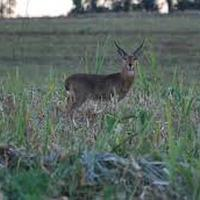

In [30]:
# list out keys and values separately
key_list = list(paths.keys())
val_list = list(paths.values())
print("Clase del animal:",val_list[5])
display(Image.open(key_list[5]))

Clase del animal: bear


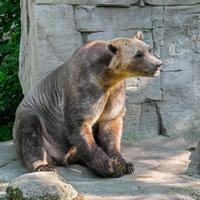

In [31]:
print("Clase del animal:",val_list[60])
display(Image.open(key_list[60]))

Clase del animal: badger


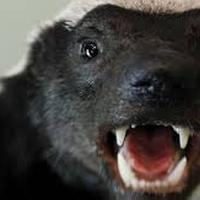

In [32]:
print("Clase del animal:",val_list[140])
display(Image.open(key_list[140]))

In [6]:
#Leer las imágenes
#path = "animals"
#paths = {}

#for ani in os.listdir(path):
#    print(f'Cantidad de {ani}: {len(os.listdir(path + "/" + ani))}')
#    for i in os.listdir(path + "/" + ani):
#        id = path + "/" + ani + "/" + os.path.splitext(i)[0]
#        im = Image.open(id  + '.jpg')
#        im.save(id + '.png')
#        os.remove(id  + '.jpg') 
#        idn = path + "/" + ani + "/" + os.path.splitext(i)[0] + '.png'
#        paths[idn] = ani

In [33]:
#Leer las imágenes
path = "animals"
paths = {}

for ani in os.listdir(path):
    print(f'Cantidad de {ani}: {len(os.listdir(path + "/" + ani))}')
    for i in os.listdir(path + "/" + ani):
        id = path + "/" + ani + "/" + os.path.splitext(i)[0] + '.png'
        paths[id] = ani

Cantidad de antelope: 60
Cantidad de bear: 60
Cantidad de badger: 60
Cantidad de bat: 60


In [35]:
img_array = []
classes = []
values = []
#Leer las imagenes y guardar como array 
for i in paths:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    # pixeles como float 32 bits
    img = img.astype('float32')
    img_array.append(img)

In [36]:
#A cada clase le asignamos un valor ya que es más rápido en lugar de número que string 
for i in paths.values():
    if i not in classes:
        classes.append(i)
    # se usa el indice como valor de referencia
    values.append(classes.index(i))

In [37]:
#Convetir de listas a numpy 
x = np.array(img_array)
y = np.array(values)

In [42]:
#90% de datos para entrenamiento y 20% de pruebas
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((216, 200, 200), (216,)), ((24, 200, 200), (24,)))

In [43]:
# Convertir a torch
# Y al mismo tiempo Reshape las imagenes para que sean más fácil de calcular
X_train = X_train.reshape(X_train.shape[0], 1, 200, 200)
X_train = torch.from_numpy(X_train)
X_test = X_test.reshape(X_test.shape[0], 1,200, 200)
X_test  = torch.from_numpy(X_test)
y_train = y_train.astype(int)
y_train = torch.from_numpy(y_train)
y_test = y_test.astype(int)
y_test = torch.from_numpy(y_test)

In [44]:
class Red(Module):   
    def __init__(self):
        super(Red, self).__init__()

        self.capas_cnn = Sequential(
            # convolucion 2D
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # convolucion 2D
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.capas_comunes = Sequential(
            Linear(10000, len(classes))
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.capas_cnn(x)
        x = x.view(x.size(0), -1)
        x = self.capas_comunes(x)
        return x

In [45]:
modelo = Red()
# Definir el ptimizador
optimizer = Adam(modelo.parameters(), lr=0.07)
# Función de perdida
criterion = CrossEntropyLoss()
print('-------------------------------------------------------')
print("Modelo")
print(modelo)
print('-------------------------------------------------------')
print("optimizer")
print(optimizer)
print('-------------------------------------------------------')
print("criterion")
print(criterion)

-------------------------------------------------------
Modelo
Red(
  (capas_cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (capas_comunes): Sequential(
    (0): Linear(in_features=10000, out_features=4, bias=True)
  )
)
-------------------------------------------------------
optimizer
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.07
    maximize: False
    weight_decay: 0
)
----------------------------------------------------

In [46]:
#Función: train
#Dominio: número natural que representa la cantidad de época
#Codominio: NULL
#Esta función se encarga de entrenar el modelo
def train(epoch):
    modelo.train()
    tr_loss = 0
    # datos de entrenamiento y pruebas
    xtrain, ytrain = Variable(X_train), Variable(y_train)
    xval, yval = Variable(X_test), Variable(y_test)

    # Limpiar gradientes en parametros
    optimizer.zero_grad()
    
    # Predicir entrenamiento 
    res_train = modelo(xtrain)
    res_val = modelo(xval)

    # Calcular la pérdida
    p_train = criterion(res_train, ytrain)
    p_val = criterion(res_val, yval)
    train_p.append(p_train)
    test_p.append(p_val)

    # Actualizar pesos
    p_train.backward()
    optimizer.step()
    tr_p = p_train.item()
    if epoch%10 == 0:
        print('Epoch : ',epoch+1, '\t', 'pérdida :', p_val)

In [47]:
# Definir cantidad de época
n_epochs = 150
train_p = []
test_p = []
# Entrenar el modelo
for epoch in range(n_epochs):
    print('-------------------------------------------------------')
    train(epoch)

Epoch :  1 	 pérdida : tensor(1.6296, grad_fn=<NllLossBackward0>)


# Resultados con datos de entrenamientos

In [48]:
# Predicción de entramiento
with torch.no_grad():
   res = modelo(X_train)
    
softmax = torch.exp(res).cpu()
pro = list(softmax.numpy())
answers = np.argmax(pro, axis=1)

In [49]:
#Accuracy
accuracy_score(y_train, answers)

0.37962962962962965

In [50]:
#f1_score
f1_score(y_train, answers,average=None)

array([0.4953271 , 0.        , 0.25641026, 0.44186047])

In [51]:
#recall
recall_score(y_train, answers,average=None)

array([0.96363636, 0.        , 0.18867925, 0.35185185])

In [54]:
#Precision
precision_score(y_train, answers,average=None)

/home/te/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.33333333, 0.        , 0.4       , 0.59375   ])

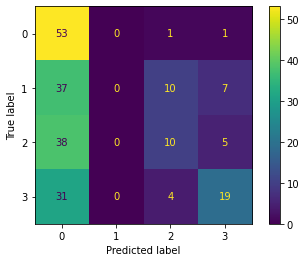

In [55]:
#confusion_matrix
cm = confusion_matrix(y_train, answers)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Curva de error con  entrenamiento

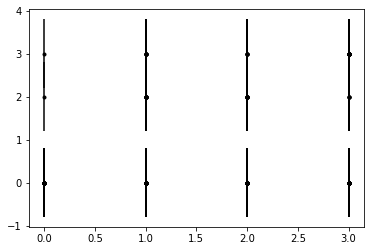

In [56]:
plt.errorbar(y_train, answers, yerr=0.8, fmt='.k');

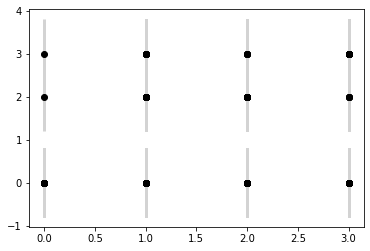

In [57]:
plt.errorbar(y_train, answers, yerr=0.8, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

# Resultados con datos de pruebas

In [58]:
# prediccion de pruebas
with torch.no_grad():
    res = modelo(X_test)

softmax = torch.exp(res).cpu()
pro = list(softmax.numpy())
ans = np.argmax(pro, axis=1)

In [59]:
#accuracy
accuracy_score(y_test, ans)

0.375

In [60]:
#f1_score
f1_score(y_test, ans,average=None)

array([0.43478261, 0.        , 0.        , 0.66666667])

In [61]:
#recall
recall_score(y_test, ans,average=None)

array([1.        , 0.        , 0.        , 0.66666667])

In [62]:
#precision
precision_score(y_test, ans,average=None)

/home/te/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.27777778, 0.        , 0.        , 0.66666667])

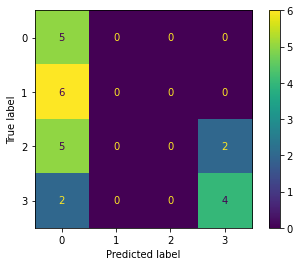

In [63]:
#confusion_matrix
cm = confusion_matrix(y_test, ans)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Curva de error con  pruebas


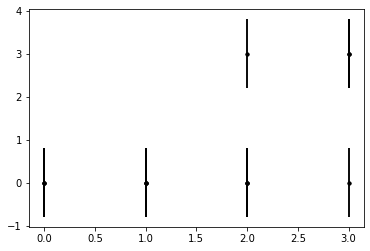

In [64]:
plt.errorbar(y_test, ans, yerr=0.8, fmt='.k');

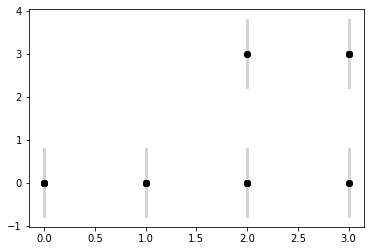

In [65]:
plt.errorbar(y_test, ans, yerr=0.8, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

## Prueba con ejemplo

In [66]:
# prediccion de prueba
# Cargar imagen de prueba
test_img = []
img = cv2.imread("animals/badger/3cf13ad980.png", cv2.IMREAD_GRAYSCALE)
img = img.astype('float32') # pixel a float 32
test_img.append(img)
test_img = np.array(test_img) #Convertir a array
print(test_img)
# imagenes a torch
test_img = test_img.reshape(1, 1, 200, 200)
test_img  = torch.from_numpy(test_img)

[[[149. 157. 157. ... 151. 159. 166.]
  [154. 163. 164. ... 152. 156. 161.]
  [154. 161. 164. ... 152. 153. 156.]
  ...
  [152. 141. 131. ... 126. 116. 130.]
  [145. 140. 137. ... 103. 131. 152.]
  [147. 145. 144. ... 106. 151. 151.]]]


In [67]:
name = []
name.append(animals.index('badger'))

# prueba prediccion
with torch.no_grad():
    res = modelo(test_img)

softmax = torch.exp(res).cpu()
prob = list(softmax.numpy())
ani = np.argmax(prob, axis=1)

print("Animal:")
print(name[0])
print("Resultado de predición:")
print("ID de animal",ani[0])
print("Nombre de animal",animals[ani[0]])

if(name[0]==ani[0]):
    print("El resultado de predcción es correcto")
else:
    print("El resultado de predcción no es correcto")    

Animal:
1
Resultado de predición:
ID de animal 2
Nombre de animal bat
El resultado de predcción no es correcto


### Análsis de resultados
- Los resultados obtenidos estuvieron normales, creemos que la causa es porque no hizo un buen preprocesamiento de imágenes y el modelo no cuenta con un valor grande de época. A lo largo de este proyecto, estuvimos probando con diferentes valores de época, y nos dimos cuenta que si el número de época es un valor grande posiblemente el resultado sea mejor.
- Las curvas de error son utilizadas para indicar el error que se estima en una medida y en este caso consideramos que los errores no fueron tan graves a pesar de que usamos muy poco datos. 

### Posibles mejoras


- Creemos que el tiempo de ejecución puede mejorar si reducimos la dimensionalidad de las imagenes,
debido a qué con 5 clases de animales se duran como 2 horas entrenando el modelo con 5 épocas.

- El otro factor muy imporante es encontrar los hiperparáemtros más adecuados, para esto se debe realizar diferentes pruebas, y nos dimos cuenta mientras más capas entrenen el modelo y el resultado se ve mejor. 

- También pensamos que se debe realizar un mejor procesamiento de imágenes como aplicando diferentes filtros

### Conclusiones
- Al final solo utilizamos 5 clases de animales para entrenar el modelo, y el resultado obtenido no es tan bueno como lo esperábamos, pero creemos que está mejor que el de sentimiento de análisis debido a que utilizamos menos datos para el entrenamiento.
- Nos gustó este ejercicio, debido a que pudimos aplicar procesamiento de imágenes, al mismo tiempo entender mejor los otros temas vistos en la clase.
- Creemos que el resultado hubiera sido mejor si entrenáramos con más datos y realizar un análisis más profundo de los hiperparámetros
- Después de realizar pruebas con diferentes dimensionalidad de imágenes llegamos a concluir que la mejor manera es normalizar y ajustar para que todas las imágenes sean del mismo tamaño, ya que esto ayuda a tener un patrón más claro y fácil de procesar y al mismo tiempo mejorará los resultados

### Referencias
- Curso de Inteligencia Artificial: Semana 10, Semana 11, Semana 12 y Semana 13. Curso impartido y diseñado por la profesora María Auxiliadora Mora Cross
- Anónimo. (s.f.). Python cv2.IMREAD_GRAYSCALE Examples. https://www.programcreek.com/python/example/70414/cv2.IMREAD_GRAYSCALE
